# Import Library

In [1]:
import os
import torch
import torchvision 
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd

# Config

In [3]:
# google colab free gpu 사용 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [4]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
EPOCHS = 350
BATCH_SIZE = 100
sample_dir = 'samples'

In [5]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


# Load Data

In [33]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
                ])

In [34]:
# Loading trainset, testset and trainloader, testloader
trainset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = True,
                                        download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)


testset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = False,
                                        download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


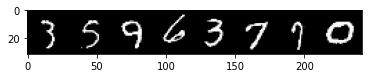

In [36]:
# visualization 

data, label = next(iter(trainloader))

img = torchvision.utils.make_grid(data[0:8])
plt.imshow(img.permute(1,2,0))
ax = plt.gca()
plt.show()
# plt.savefig('./tmp.png')

In [41]:
print(data.min())
print(data.max())

tensor(-1.)
tensor(1.)


# GAN

In [47]:
# class Generator(nn.Module):
#   def __init__(self, image_size, latent_size):
#     super(Generator, self).__init__()

#     def block(in_feat, out_feat, normalize=True):
#       layers = [nn.Linear(in_feat, out_feat)]
#       if normalize:
#         layers.append(nn.BatchNorm1d(out_feat, 0.8))
#       layers.append(nn.ReLU())

#       return layers

#     self.model = nn.Sequential(
#         *block(latent_size, 256, normalize=False),
#         # *block(128, 256),
#         # *block(256, 512),
#         nn.Linear(256, image_size),
#         nn.Tanh()
#     )

#   def forward(self, z):
#     img = self.model(z)

#     return img


class Generator(nn.Module):
  def __init__(self, image_size, latent_size):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(latent_size, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, image_size),
        nn.Tanh()
    )

  def forward(self, z):
    img = self.model(z)

    return img  

In [48]:
# class Discriminator(nn.Module):
#   def __init__(self, image_size):
#     super(Discriminator, self).__init__()

#     def block(in_feat, out_feat, normalize=True):
#       layers = [nn.Linear(in_feat, out_feat)]
#       if normalize:
#         layers.append(nn.BatchNorm1d(out_feat, 0.8))
#       layers.append(nn.ReLU())
#       return layers

#     self.model = nn.Sequential(
#         *block(image_size, 256, normalize=False),
#         # *block(512, 256),
#         # *block(256, 128),
#         nn.Linear(256, 1),
#         nn.Sigmoid()
#     )

#   def forward(self, img):
#     img_flat = img.view(img.size(0), -1)
#     output = self.model(img_flat)

#     return output 

class Discriminator(nn.Module):
  def __init__(self, image_size):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(image_size, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

  def forward(self, img):
    img_flat = img.view(img.size(0), -1)
    output = self.model(img_flat)

    return output 


In [49]:
# Initialize generator and discriminator

D = Discriminator(image_size)
G = Generator(image_size, latent_size)

In [50]:
# Loss function & Optimizer 
criterion = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

D.to(DEVICE)
G.to(DEVICE)

Generator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

# Train

In [51]:
total_step = len(trainloader)


g_epoch_loss = []
d_epoch_loss = []

for epoch in range(EPOCHS):
  d_loss_total = []
  g_loss_total = [] 
  for i, (images, _) in enumerate(trainloader):
    images = images.to(DEVICE)

    real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
    fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

    #-- Discriminator
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(BATCH_SIZE, latent_size).to(DEVICE)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake 
    d_loss_total.append(d_loss.item())

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #-- Generator 
    z = torch.randn(BATCH_SIZE, latent_size).to(DEVICE)
    fake_images = G(z)
    outputs = D(fake_images)

    g_loss = criterion(outputs, real_labels)
    g_loss_total.append(g_loss.item())

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, EPOCHS, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
  if (epoch+1) == 1:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(images, os.path.join(sample_dir, 'real_images.png'))

  fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
  save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

  g_epoch_loss.append(np.mean(g_loss_total))
  d_epoch_loss.append(np.mean(d_loss_total))


Epoch [0/350], Step [200/600], d_loss: 0.0337, g_loss: 4.2554, D(x): 1.00, D(G(z)): 0.03
Epoch [0/350], Step [400/600], d_loss: 0.0349, g_loss: 5.7142, D(x): 0.99, D(G(z)): 0.02
Epoch [0/350], Step [600/600], d_loss: 0.0899, g_loss: 5.3483, D(x): 0.96, D(G(z)): 0.05
Epoch [1/350], Step [200/600], d_loss: 0.0445, g_loss: 5.3975, D(x): 0.98, D(G(z)): 0.02
Epoch [1/350], Step [400/600], d_loss: 0.1584, g_loss: 4.0511, D(x): 0.97, D(G(z)): 0.11
Epoch [1/350], Step [600/600], d_loss: 0.5957, g_loss: 4.5102, D(x): 0.82, D(G(z)): 0.11
Epoch [2/350], Step [200/600], d_loss: 0.3696, g_loss: 4.2820, D(x): 0.86, D(G(z)): 0.04
Epoch [2/350], Step [400/600], d_loss: 0.5023, g_loss: 2.1552, D(x): 0.81, D(G(z)): 0.13
Epoch [2/350], Step [600/600], d_loss: 0.5903, g_loss: 2.6834, D(x): 0.80, D(G(z)): 0.15
Epoch [3/350], Step [200/600], d_loss: 0.4904, g_loss: 3.4423, D(x): 0.80, D(G(z)): 0.11
Epoch [3/350], Step [400/600], d_loss: 0.3979, g_loss: 3.6568, D(x): 0.91, D(G(z)): 0.18
Epoch [3/350], Step [

# Loss Visualization 

In [52]:
import matplotlib.pyplot as plt

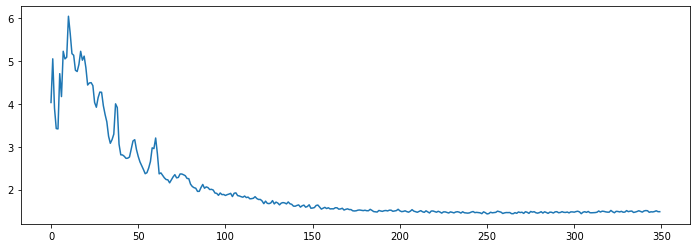

In [53]:
plt.figure(figsize=(12,4))
plt.plot(range(len(g_epoch_loss)), g_epoch_loss)
plt.show()

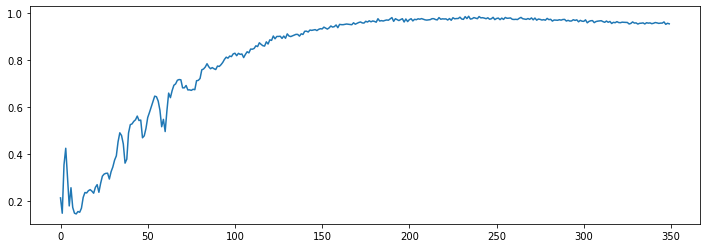

In [54]:
plt.figure(figsize=(12,4))
plt.plot(range(len(d_epoch_loss)), d_epoch_loss)
plt.show()

# fake images

In [55]:
import cv2

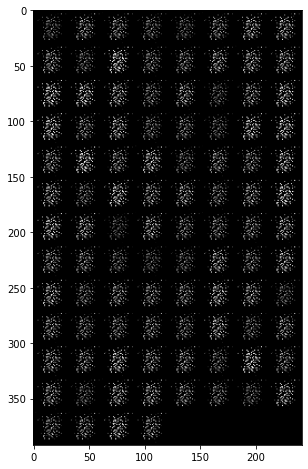

In [56]:
# iter 1 
img = cv2.imread("./samples/fake_images-1.png") # 이미지 불러오기

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

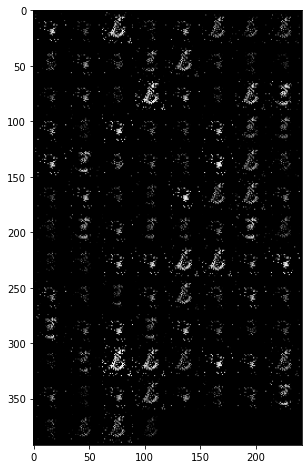

In [57]:
# iter 10
img = cv2.imread("./samples/fake_images-10.png") # 이미지 불러오기

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

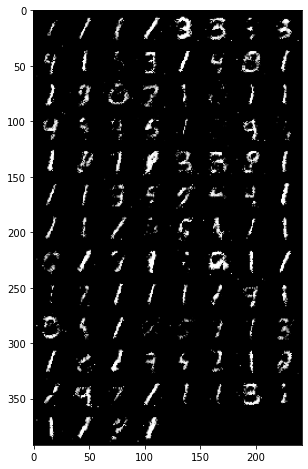

In [58]:
# iter 50
img = cv2.imread("./samples/fake_images-50.png") # 이미지 불러오기

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

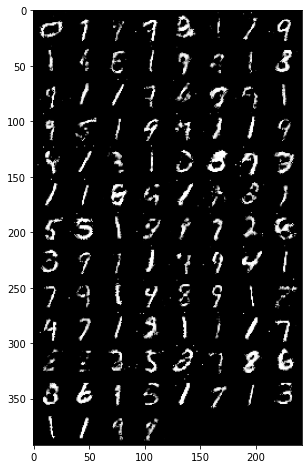

In [59]:
# iter 100
img = cv2.imread("./samples/fake_images-100.png") # 이미지 불러오기

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

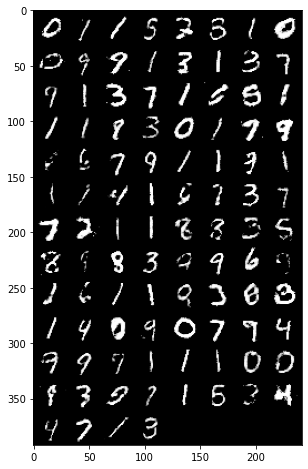

In [60]:
# iter 200
img = cv2.imread("./samples/fake_images-200.png") # 이미지 불러오기

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

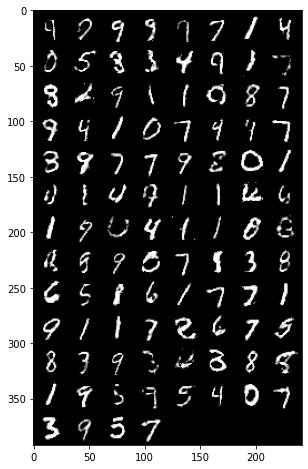

In [61]:
# iter 300
img = cv2.imread("./samples/fake_images-300.png") # 이미지 불러오기

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

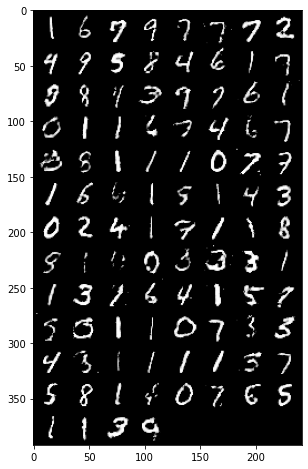

In [62]:
# iter 350
img = cv2.imread("./samples/fake_images-350.png") # 이미지 불러오기

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()